In [1]:
# [作業目標]
# 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
# 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
# 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
# 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [2]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

In [3]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [4]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)



In [6]:
# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
birth = np.round(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365)

In [7]:
equal_width_birth = pd.cut(birth, 6)
equal_width_birth.value_counts()


(37.0, 45.0]      61625
(29.0, 37.0]      57671
(45.0, 53.0]      51215
(53.0, 61.0]      50460
(20.952, 29.0]    36385
(61.0, 69.0]      25330
Name: DAYS_BIRTH, dtype: int64

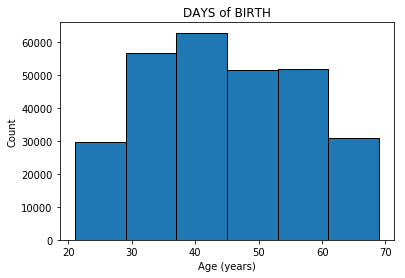

In [8]:
plt.hist(birth, edgecolor = 'k', bins = 6)
plt.title('DAYS of BIRTH'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

In [22]:
equal_freq_birth = pd.qcut(birth, 6)
equal_freq_birth.value_counts()

(43.0, 51.0]      52617
(31.0, 38.0]      51633
(20.999, 31.0]    50447
(51.0, 58.0]      45511
(58.0, 69.0]      43203
(38.0, 43.0]      39275
Name: DAYS_BIRTH, dtype: int64

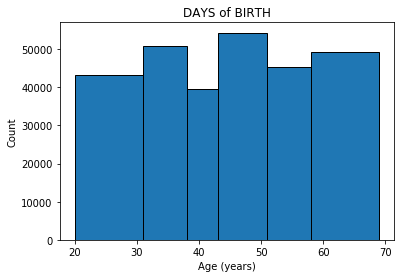

In [19]:
plt.hist(birth, edgecolor = 'k', bins = (20, 31, 38, 43, 51, 58, 69))
plt.title('DAYS of BIRTH'); plt.xlabel('Age (years)'); plt.ylabel('Count');
plt.show()

In [20]:
??pd.qcut